# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #3
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, Febrary 16th, 2018 at 10:59am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats 
import time
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.


### Table of Contents

1. [Visualizing Our Loss Function](#viz)

2. [Review of Optimization Via Gradient Descent](#review_grad)

3. [Review of Optimization Via Gradient Descent & Mini-Batch Descent](#review_approx)

4. [Implementation: Gradient Descent](#implement_grad)

5. [Implementation: Stochastic Gradient Descent](#implement_rand)

6. [Comparison: Gradient Descent vs Stochastic Gradient Descent](#compare)


### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

**Solutions:**

<a id='viz'></a>
### Visualizing Our Loss Function
Given our loss function $L(x, y, \lambda_1, \lambda_2)$ at the coordinate $(x, y)$ and for the set of parameter settings $(\lambda_1, \lambda_2)$, the ***total loss*** over the entire set of coordinates in the data is
\begin{aligned}
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2) &= \sum_{i=1}^N\left[0.000045\lambda_2^2 y_i - 0.000098\lambda_1^2 x_i + 0.003926\lambda_1 x_i\exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\right]\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
\end{aligned}
where $N$ is total number of coordinates in our data set. Now, since the pipes are being laid down in a particular geometric pattern, namely along a hyperbola described by $y^2 - x^2 = -0.1$, we can further simplify the above as:
\begin{aligned}
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2) &= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^N x_i.
\end{aligned}
In `python`, we would write the above as
```
total_loss = 0.000045 * lambda_2**2 * y.sum() - 0.000098 * lambda_1**2 * x.sum() + 0.003926 * lambda_1 * x.sum() * np.exp(-0.1 * (lambda_1**2 + lambda_2**2))
```

Now, our task can be stated in a straightforward fashion: we wish to find values of $\lambda_1$ and $\lambda_2$ such that the total loss is minized for our set of coordinates.

> 
**A Note on Terminology:**
In optimization (the subfield of mathematics/computer science which studies methods for finding optimal solutions to mathematical systems and models), the terms "loss function", "cost funciton", "objective function" are often used interchageably. Of these terms, "objective function" is the most general. An objective function is a mathematical expression describing the perceived value of a particular set of outcomes of circumstances (e.g. an objective function can describe your expected income given your work experience and eduction, the expected duration of a marriage given the length and quality of conflicts, the revenue of a company given the quantity of goods produced and the unit retail price, etc). The chief task in optimization is to maximize or minize your objective function.

> 
A "loss function" or "cost function" is a specific type of objective function that you mean to *minimize* (e.g. you'd want to minimize loss or cost functions like poverty levels or the lengths of winter months). While functions you'd mean to maximize are typically called "utility functions" or "fitness functions" (e.g. you'd like to maximize revenue, expected income etc).

> 
In gradient ***descent*** we seek the minimum of objective functions by iteratively descreasing the objective using the gradient. Thus, for gradient descent our objective functions are called "loss functions" or "cost functions".

Now before running ***any*** optimization algorithms on our objective function, we must do some exploration of our function, either by analysis or visualization! This step is important for the following reasons:

1. iteratively following the gradient (the direction of maximum increase or decrease in the objective function at a point) ***does not*** guarantee that you will end in a global maximum or minimum. In fact, if your function has local maxima, local minima or saddle points (at which the gradient is zero - these are called stationary points), your gradient descent may very well become trapped at these points. In this sense, where you initialize your gradient descent algorithm becomes very important. Some initializations will lead you to an undesirable stationary point, while others will lead you to your global maximum or minimum. 

2. analytical, numerical or visual explorations of your function can help you determine appropriate step sizes for your descent algorithms (would $\eta = 0.001$ be appropriate or $\eta=1000$?).



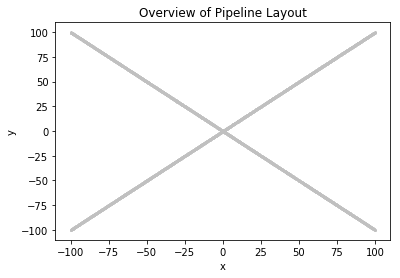

In [2]:
#Visualization of the data - what does the pipeline look like?
x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

plt.scatter(x, y, color='silver', s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Overview of Pipeline Layout')
plt.show()

In [3]:
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#Total loss
def L(l1, l2, x, y):
    total_loss = 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))
    return total_loss


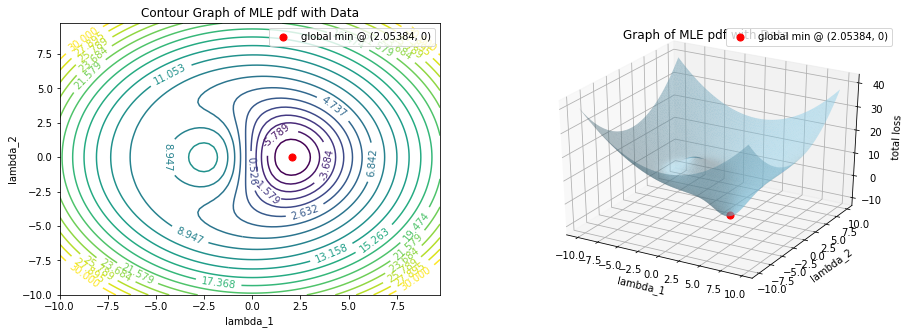

In [4]:
#cover the domain of the pdf with a grid and get the coordinates of the grid vertices
delta = 0.25
l1 = np.arange(-10, 10, delta)
l2 = np.arange(-10, 10, delta)
l1, l2 = np.meshgrid(l1, l2)

loss = L(l1, l2, x, y)

fig = plt.figure(figsize=(15, 5))


#plot contour map of pdf with data in R^2 (Cartesian plane)
ax1 = fig.add_subplot(121) 
contour = ax1.contour(l1, l2, loss, levels=np.linspace(-10, 30, 20))
ax1.scatter([2.05384], [0], color='red', s=50, label='global min @ (2.05384, 0)')
ax1.clabel(contour, inline=1, fontsize=10)
ax1.set_title('Contour Graph of MLE pdf with Data')
ax1.set_xlabel('lambda_1')
ax1.set_ylabel('lambda_2')
ax1.legend(loc='best')

#plot 3D suface of pdf in R^3, with data in R^2
ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot_trisurf(l1.flatten(), l2.flatten(), loss.flatten(), linewidth=0.2, antialiased=True, color='skyblue', alpha=0.5)
ax2.scatter([2.05384], [0], [L(2.05384, 0, x, y)], color='red', s=50, label='global min @ (2.05384, 0)')
ax2.set_xlabel('lambda_1')
ax2.set_ylabel('lambda_2')
ax2.set_zlabel('total loss')
ax2.set_title('Graph of MLE pdf with Data')
ax2.legend(loc='best')

plt.show()

From the above, we see that the total loss is minimized at $(\lambda_1, \lambda_2) = (2.05384, 0)$. 

There is also a saddle point near (-5,0), and the function is quite flat in that region. Because the gradients are small there, gradient descent algorithms can (depending on the learning rate) get trapped there for a substantial time.

In [13]:
print('The minumum total cost:', L(2.05384, 0, x, y))
print("The saddle point's cost:", L(-5, 0, x, y))

The minumum total cost: -9.9341040253
The saddle point's cost: 8.27609833927


<a id="review_grad"></a>
### Review of Optimization Via Gradient Descent
(***The following reviews the basic concepts behind the gradient descent algorithm, in response to questions during office hours. You may wish to skip directly to implementation if you are solid on the theoretical background behind these methods.***)

The intuition behind various flavours of gradient descent is as follows:

0. we imagine we are walking on the graph of our objective function. In our case, our objective function is a function of two real variables and so its graph is a surface in $\mathbb{R}^3$. In this analogy, the global minimum of the function occurs at the bottom of the lowest valley on this surface (see upper right graph).

1. we want to descend (climb downhill) as quickly as possible. So, after taking each step, we take the gradient of the objective function at our current position,
$$
\nabla Total Loss (\lambda^{current}_1, \lambda^{current}_2) = \left\langle\frac{\partial Total Loss}{\partial \lambda_1}, \frac{\partial Total Loss}{\partial \lambda_2} \right\rangle
$$
The gradient is a vector pointing towards the direction of steepest ascent (the fastest way up). Therefore, the negative of the gradient is a vector pointing towards the direction of steepest descent (the fastest way down).
<img src='grad.pdf'>
The gradient, in our case, contains two components: an update in the $\lambda_1$ direction ($\frac{\partial Total Loss}{\partial \lambda_1}$ is an instruction to move $\frac{\partial Total Loss}{\partial \lambda_1}$ units from your current position in the $\lambda_1$ direction), and a similar update in the $\lambda_2$ direction. However, we may only wish to take a fraction, $\eta$, of a step in the direction of the negative gradient. Thus, our new position can be expressed as:
\begin{aligned}
\langle\lambda^{new}_1, \lambda^{new}_2\rangle &= \langle\lambda^{old}_1, \lambda^{old}_2\rangle - \eta\left\langle\frac{\partial Total Loss}{\partial \lambda_1}, \frac{\partial Total Loss}{\partial \lambda_2} \right\rangle\\
&= \left\langle \lambda^{old}_1 - \eta \frac{\partial Total Loss}{\partial \lambda_1}, \lambda^{old}_2 - \eta \frac{\partial Total Loss}{\partial \lambda_2}\right\rangle
\end{aligned}

2. we repeat the process of stepping in the negative gradient direction and computing a new gradient until we are no longer make significant progress becuase the gradients have become close to zero. This means that the algorithm terminates at locations where the objective is flat enough- this occurs in regions around a minimum, and also around saddle points and other plateaus.

The gradient descent algorithm pseudo-code:
```
Algorithm 1:

start at random place: lambdas = [random_value_1, random_value_1]
until (stopping condition satisfied):
    compute gradient: gradient = gradient_function(lambdas, data)
    take a step in the negative gradient direction: 
    lambdas = lambdas - eta * gradient
```

<a id="review_approx"></a>
### Review of Optimization Via Gradient Descent & Mini-Batch Descent
(***The following reviews the basic concepts behind stochastic and mini-batch gradient descent algorithms, in response to questions during office hours. You may wish to skip directly to implementation if you are solid on the theoretical background behind these methods.***)

Note that in the gradient descent algorithm, computing the gradient $\frac{\partial Total Loss}{\partial \lambda_i}$ requires us to compute $\sum_{i=1}^N x_i$ and $\sum_{i=1}^N y_i$ (see definition of the total loss function. Suming up the $x$, $y$ values over the entire dataset is trivial when the dataset is small, but these operations become infeasible or undesirable when the data is truly large (cannot be physically stored on a single machine, for example). In this case, we ***approximate*** the true gradient of the loss function $Total Loss$ with the gradient of a approximate loss function $\widetilde{Total Loss}$, where, after permuting our data, 
$$
Total Loss \approx \widetilde{Total Loss} = 0.000045\lambda_2^2 \sum_{i=1}^\tilde{N} y_i - 0.000098\lambda_1^2 \sum_{i=1}^\tilde{N} x_i + 0.003926\lambda_1 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^\tilde{N} x_i.
$$
That is, $\widetilde{Total Loss}$ is just $Total Loss$ evaluated at a random selection of a small *subset* of the data. 

In this version of events, we seek the global minimum by following approximations, $\nabla \widetilde{Total Loss}$, of the true gradient, $\nabla Total Loss$. 

Our approximate gradient descent algorithm is:
```
Algorithm 2:

start at random place: lambdas = [random_value_1, random_value_1]
until (stopping condition satisfied):
    randomly shuffle the data
    divide the data into segments, with N_tilde elements in each segment
    for each data_segment do:
        compute approximate gradient: approx_grad = gradient_function(lambdas, data_segment)
        take a step in the negative approximate gradient direction: 
        lambdas = lambdas - eta * approx_grad
```
A couple of important observations:

1. When $\tilde{N} = N$ then the "approximate" gradient descent algorithm is just regular old gradient descent. 

2. When $\tilde{N} = 1$ then the "approximate" gradient descent algorithm is called ***stochastic gradient descent***.

3. When $\tilde{N} < N$ then the "approximate" gradient descent algorithm is called ***mini-batch descent***.



**[Bad] Alternative Algorithm**  
The above algorithm samples from the data without replacement- once a data point has been used it is out of comission until the end of the epoch. Why not use a simpler algorithm that samples with replacement- why not just grab N points from the full dataset each update?

The issue is that sampling without replacement means we might wait a long time before we sample influential points. For example, if 2% of the data have a big impact on the total loss we want to be sure that these data are incoporated on an appropriate number of updates and not (by chance) only in 0.5% of updates or in 4% of updates. Structuring the algorithm into epochs forces each data point shows up the right percentage of the time. This can be seen as a particular agressive form of stratification.


<a id="implement_grad"></a>
### Implementation: Gradient Descent

We first calculate the gradient of our total loss function,
\begin{aligned}
\frac{\partial TotalLoss}{\partial \lambda_1} =&  -2 * 0.000098\lambda_1 \sum_{i=1}^{N} x_i + 0.003926 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i \\
& - 0.1 * 0.003926 * 2 * \lambda_1^2 * \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i\\
\frac{\partial TotalLoss}{\partial \lambda_2} =&\,  2 * 0.000045\lambda_2^2 \sum_{i=1}^{N} y_i - 0.1 * 2 *  0.003926\lambda_1  \lambda_2 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i.\\
\nabla TotalLoss =&\, \left\langle\frac{\partial TotalLoss}{\partial \lambda_1}, \frac{\partial TotalLoss}{\partial \lambda_2} \right\rangle .
\end{aligned}

In [6]:
#The gradient of the total loss function

def grad(l1, l2, x, y):

    l1_grad = -0.000098 * 2 * l1 * x.sum() + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2))
    l2_grad = 2 * 0.000045 * l2 * y.sum() - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))
    return np.array([l1_grad, l2_grad])

A note on the correct loss function to use:

> **Total Loss or Average Loss?** If we're just interested in minimizing the loss, minimizing total loss is equivalent to minimizing average loss. This is because
$$
Average Loss = \frac{1}{N} TotalLoss
$$
Clearly, since $N$ is a constant, when total loss is minimized then average loss is minimized (and vice versa). However, if we are interested in comparing the performance of gradient descent with that of stochastic gradient descent, we need to find a loss function that facilitates a fair comparison. 

> If we use the total loss for both descent algorithm, then the gradient for gradient descent will tend to be much larger (since in gradient descent, we sum over the entire dataset to compute the gradient, whereas in stochastic gradient descent, we use only one pair of coordinates to compute the gradient). Larger gradients will tend to yield larger steps in our descent, which, in turn, will tend to result in faster convergence. 

> To be fair, we will use the ***average loss function*** for both gradient descent and stochastic gradient descent. This make sense semantically as well, the loss funtion averaged over the entire data set is the expected loss for a single coordinate, whereas evaluating the loss function at a random coordinate is a way of approximating the expected loss for a single coordinate. 

> Coding wise, we just need to multiply the total cost function and the gradient function we've defined by 1/N to turn them into averages.

A note on the correct stopping condition to use:

> **Average/Total loss or lambdas?** In this problem, we know the precise location of the global minimum: (2.05384, 0), and we know the minimum total cost: -9.9341040253. So should we stop when we are sufficiently close to the optimal parameters, $(2.05384, 0)$, or should we stop when we are sufficiently close to the minimum total cost? Well, the difference is not significant and in general you can choose to use either as your stopping condition. However, since evaluating the cost at each step of the gradient descent (which involves suming over your entire dataset) is one extra computation expense, it might be more efficient to use distance to the optimal parameters as your stopping condition. 

> That is, we stop our descent when
$$
\| \langle lambda_1,  lambda_2\rangle - \langle 2.05384, 0 \rangle \|_2 < 1e^{-3}
$$
where $\| \cdot \|_2$ is the $\ell_2$ norm or the Euclidean distance.

In [7]:
#Gradient Descent
def gradient_descent(x, y, lambdas_init, init_shuffle=False, step_size=0.001, maxsteps=None, precision=1e-3, scaling=1.):
    
    lambdas = lambdas_init
    history = [lambdas] # to store all parameters
    counter = 0

    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]

    #Do descent while stopping condition not met
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        #get gradient of average loss function
        gradient = grad(lambdas[0], lambdas[1], x, y) * 1. / N
        #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
        #of course you can just directly adjust the stepsize
        lambdas = lambdas -  step_size * gradient * scaling 
        #add our new parameters to the history
        history.append(lambdas)
        #tick off one more step
        counter +=1
        
        #if we've hit maximum steps allowed, stop!
        if maxsteps is not None:
            if counter == maxsteps:
                break
        
    return history

**WARNING** This code (and the SGD code) includes a "scaling" fudge factor of 1000, effectively using $\lambda=1$, and targeting average loss.

It happens that the recommended learning rate of .001 is just too small when working with the average loss: the walker barely moves at all, whether in GD or SGD.

time to compute one gradient:  0.0009899139404296875
how many iters:  43545
final cost: -9.93410274855
precision to actual param: 0.000999868898541


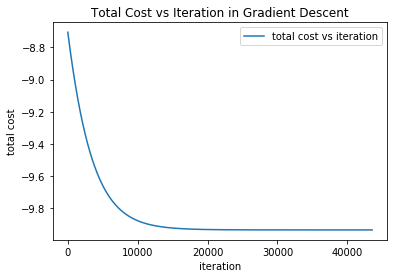

In [8]:
lambdas_init = [2, 1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x, y) * 1./len(x)
end = time.time() 

history = gradient_descent(x, y, lambdas_init, step_size=0.001, scaling=1000., maxsteps=100000)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)

print ('time to compute one gradient: ', end - start)
print ('how many iters: ', len(history))
print ('final cost:', costs[-1])
print ('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

plt.plot(range(len(costs)), costs, label='total cost vs iteration')
plt.xlabel('iteration')
plt.ylabel('total cost')
plt.title('Total Cost vs Iteration in Gradient Descent')
plt.legend(loc='best')
plt.show()

We see that we are within tolerance of our optimal parameters after 43,545 steps in the gradient descent algorithm. From the visualization of the total cost versus iteration, we see that initially we were making large updates to our parameters (the total cost was changing quickly), but towards the end the updates to our parameters became smaller and smaller (the total cost was not changing very much from iteration to iteration). This is expected, as the gradient around the global minimum in our case should be close to zero, resulting in very small step-sizes in our descent.

<a id="implement_rand"></a>
### Implementation: Stochastic Gradient Descent

The algorithm for Stochastic Gradient Descent is nearly identical to gradient descent, except for the fact that when we compute the gradient, we feed the gradient function a single coordinate rather than the entire dataset. Furthermore, we make multiple passes through the data, randomizing the dataset at the beginning each time.

In [9]:
#Stochastic Gradient Descent
def sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=1, precision=1e-3, scaling=1.):
    lambdas = lambdas_init
    history = [lambdas] # to store all thetas

    counter = 0
    epochs = 0
    i = 0 #index
        
    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]    
    
    #run through the data in multiple passes
    for epoch in range(max_epochs):
        #for each data point, compute the gradient and make an update to our parameters
        print ('epoch: ', epoch )
        for i in range(N):
            #get gradient of average loss function
            gradient = grad(lambdas[0], lambdas[1], x[i], y[i])
            #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
            #of course you can just directly adjust the stepsize
            lambdas = lambdas -  step_size * gradient * scaling 
            #add our new parameters to the history
            history.append(lambdas)   
            
            if np.linalg.norm(np.array(lambdas) - np.array([2.05384, 0])) < precision:
                return history, epoch
            elif np.any(np.isnan(lambdas)):
                return history[:-1], epoch
        
        #shuffle the data for the next pass thru
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]
    
    return history, max_epochs

epoch:  0
****************************
no initial random shuffling
****************************
time to compute one gradient:  0.0
how many iters:  15868
final loss: -9.93410285228
precision to actual param: 0.000958405055688


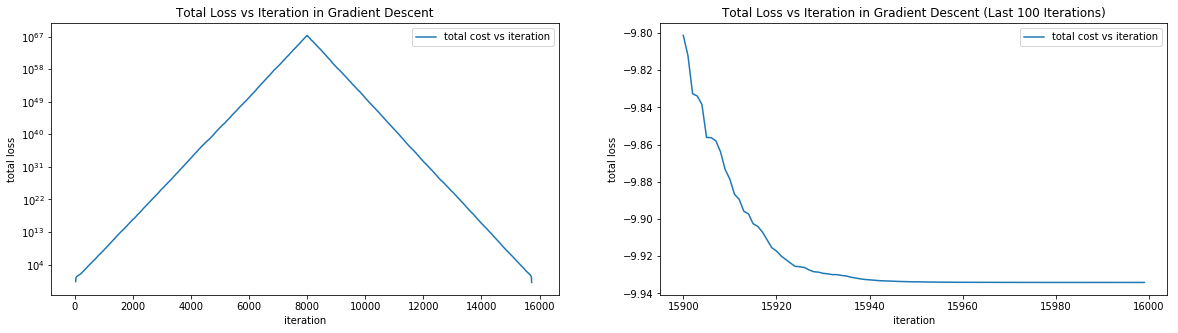

In [15]:
lambdas_init = [2, 1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print ('****************************')
print ('no initial random shuffling')
print ('****************************')
print ('time to compute one gradient: ', end - start)
print ('how many iters: ', len(history))
print ('final loss:', costs[-1])
print ('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.semilogy(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(np.arange(len(costs[-100:])) + N - 100, costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

Even though the run managed to converge, we see a strang behavior in the algorithm: the loss increases to 10^67 during the first half of the run! This happens because our data are in a non-random order. It's vital to put the data in a random order whenever you're working with an algorithm that's sensitve to the order of the data! It's not hard to find examples where the data's order make you converge to a bad optimum, or go in circles forever.


epoch:  0
****************************
WITH initial random shuffling
****************************
time to compute one gradient:  0.0
how many iters:  7447
final loss: -9.93410289461
precision to actual param: 0.000940956281245


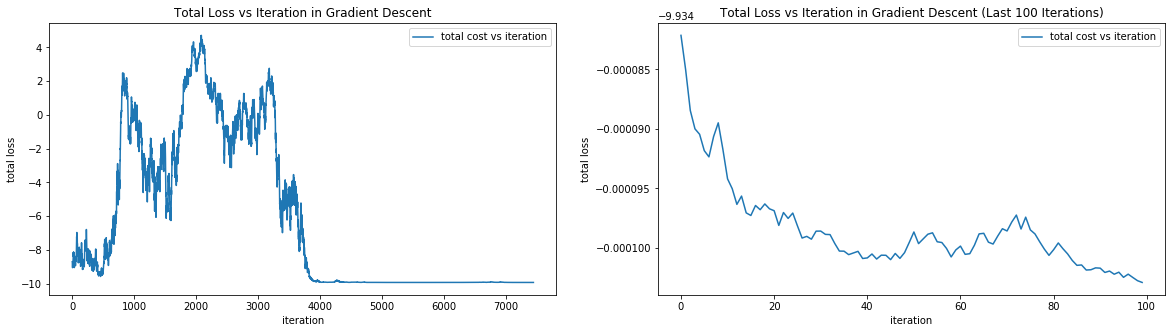

In [11]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=0.001, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print ('****************************')
print ('WITH initial random shuffling')
print ('****************************')
print ('time to compute one gradient: ', end - start)
print ('how many iters: ', len(history))
print ('final loss:', costs[-1])
print ('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

We see that we are within tolerance of our optimal parameters after less than 10,000 steps (versus the 43,545 steps it takes gradient descent). From the visualization of the total loss versus iteration, we see that we are taking paths along which the total loss rises and drops before finally stabilizing somewhat around the optimal total loss of -9.93410279384.

When we examing the total cost for the last 100 iterations, we see that stochastic gradient descent is ocillating around the optimal loss. This behavious can be worrisome if we need to obtain a higher precision solution - it's possible that stochastic gradient descent will never fall within the required tolerance.

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

**Solution:**

<a id="compare"></a>
### Comparison: Gradient Descent vs Stochastic Gradient Descent

#### Time:
We see that it takes 0.000573873519897 seconds to compute one gradient for gradient descent, while it takes around 0.000241994857788 seconds to compute one gradient for stochastic gradient descent. This is expected. We expect that computing gradients for gradient descent can take longer, given that we must perform operations on the entire set of data. However, since our dataset is relatively small and our operations (sums) are relatively light weight, the difference between these two gradient computations is minute. 

However, this will not always be the case (i.e. our data will not always be small, and the operations required to compute the gradient will not always be simple)! For example, you can try to perform gradient descent in your Long Form Homework #1 and see how that will change your training time.

#### Steps:
In our case stochastic gradient descent found the global optimum in fewer iterations. However, different problems and even different starting points can favor either GD or SGD.

GD is more accurate, and guaranteed to converge to some (possibly local) stationary point after a long enough run.
SGD is often able to skip out of local features on its way down the loss surface, but often struggles to settle at a minimum- it tends to wander near to the minimum, without necesarially converging.

Both algorithms have pitfalls, such as becoming trapped in regions where the gradients are small, such as saddle points.

## Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

**WARNING**: In this section we adjust the code's "scaling" fudge factor to the size of the dataset. Ergo, we are using the total loss function, and the rule that SGD scales up its gradients to match the full-dataset loss. [This setting gives the most interesting behavior for the stated parameters. We're going to adjust this homework to be less degenerate for the Fall session]

**Solution**



Run  0
stepsize:  0.1
epoch:  0
time to compute one gradient:  0.0
how many iters:  148
final loss: inf
precision to actual param: inf


C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys


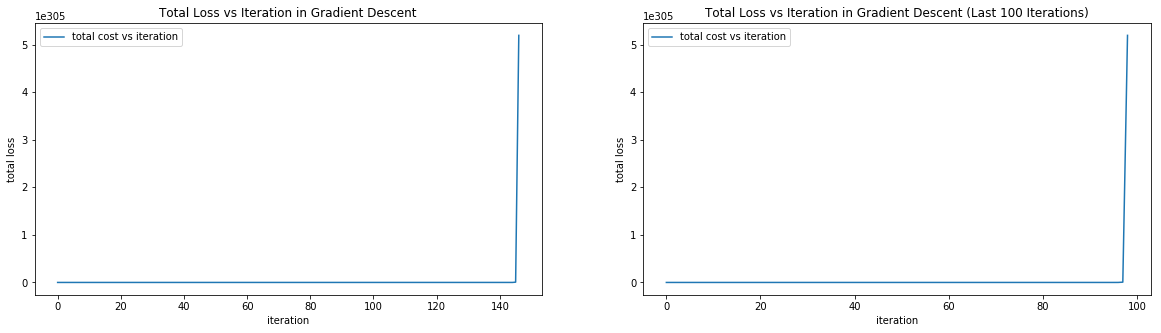



Run  1
stepsize:  0.001
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
time to compute one gradient:  0.0
how many iters:  128001
final loss: 8.16152869937
precision to actual param: 7.41708926028


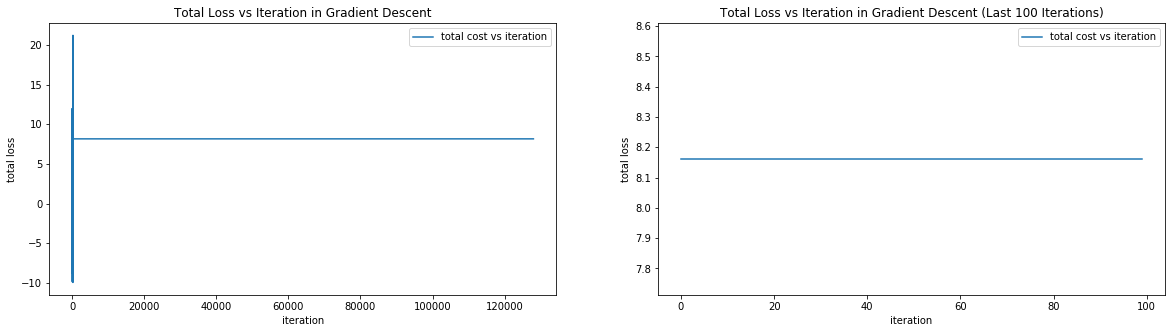



Run  2
stepsize:  0.0001
epoch:  0
time to compute one gradient:  0.0
how many iters:  1786
final loss: -9.93410284195
precision to actual param: 0.000962614345291


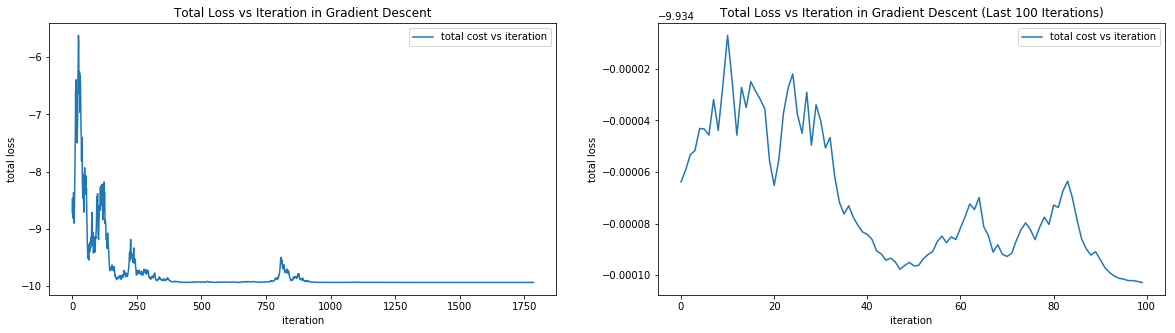

In [12]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 


for cur_run, cur_step_size in enumerate([0.1, 0.001, 0.0001]):
    print("\n")
    print("Run ",cur_run)
    print ('stepsize: ', cur_step_size)
    history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=cur_step_size, max_epochs=8, scaling=16000.)
    history = np.array(history)

    lambdas = history[-1]
    costs = L(history[:, 0], history[:, 1], x, y)
    print ('time to compute one gradient: ', end - start)
    print ('how many iters: ', len(history))
    print ('final loss:', costs[-1])
    print ('precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('total loss')
    ax1.set_title('Total Loss vs Iteration in Gradient Descent')
    ax1.legend(loc='best')

    ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('total loss')
    ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
    ax2.legend(loc='best')
    plt.show()

#### Learning rate .1
SGD diverges at a learning rate of .1 (GD converges well at this learning rate, but both algorithms diverge at a learning rate of 1). The reason is that each update vastly overshoots the minimum, sending the walker to a part of the bowl where the gradient is in the opposite direction, but even larger. This process repeats until the machine overflows.

#### Learning rate .001
This SGD run got trapped in the inflection point at (-5,0)

#### Learning rate .0001
This run converged very quickly to the true minimum.


**Summary**: For GD and SGD algorithms there is typically a "critical" learning rate that converges very quickly, with rates above that rate potentially unstable or divergent, and rates below taking longer and longer to converge.

## Problem 2. SGD for Multinomial Logistic Regresion on MNIST

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train and test with MNIST.

Your classifier will use a multinomial logistic regression model, will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think about the pixel values as features of the input vector.  Before you fully realize your model, we recommend that you plot some of the images beforehand to develop some intuition on the dataset.


1. Plot 10 sample images from the MNIST dataset
1. Construct a softmax formulation in PyTorch of multinomial logistic regression with  Cross Entropy Loss.  
1. Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs*
1. What are the training and test set accuracies?  
1. Plot some (around 5) examples of misclassifications

** The MNIST dataset (including a train/test split) is part of PyTorch in the torchvision module.  See this week's lab notebook for details of how to load it if you need help accessing it **


** Solutions **

The key parts to this solution will be creating a Multinomial Logistic Regression implementation to classify MNIST in PyTorch (784 inputs, 10 outputs, no hidden layers, CrossEntropy Loss).  We'll start our endeavors with our torch related imports.  


In [74]:
## Standard boilerplate to import torch and torch related modules
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

We'll base our class on the **Regression** parent class that we created in for the last Homework.  We'll do so in order to model our Logistic Regression class on the SKLearn API.

In [ ]:

# Regression Parent Class
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params.get(k, None)
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
        
                    
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()
        

*We've created a PyTorch Logistic Regression model based on nn.Module.  We've defined the appropriate layers (one input and the implicit output layer) in the constructor.  In forward, we run the inputs through the layers we defined.  We don't define any activation on the output layer because we'll be using CrossEntropyLoss which does the softmax activation automatically for us.*

In [ ]:
## Our PyTorch implementation of Logistic Regression
class LRPyTorch(nn.Module):

    ## the constructor is where we'll define all our layers (input, hidden, and output)
    def __init__(self):

        ## this line creates an instance of our parent (or base) class which in this case
        ## is nn.Module.
        super().__init__()

        ## in the lines below we'll create instance variables and assign them torch.nn Models
        ## in order to create our layers.  You should ordinarily have one variable definition for each layer
        ## in your neural network except for the output layer.  The output layer is defined by the number of
        ## outputs in your last layer. Since we're dealing with simple Artificial Neural Networks, we should
        ## predominantly be using nn.Linear.  
        self.l1 = nn.Linear(784, 10)

 
    # forwards takes as a parameter x -- the batch of inputs that we want to feed into our neural network model
    # and returns the output of the model ... i.e. the results of the output layer of the model after forward
    # propagation through our model. practically this means you should call each layer you defined in the
    # constructor in sequence plus any activation functions on each layer.
    def forward(self, x):
     
        # call all our layers on our input (in this case we only need one)
        x = self.l1(x)

        # Since we're using Cross Entropy Loss
        # we can return our output directly
        return x


*Create the MNIST Logistic Regression model.  We define methods to fit, predict and score our model as well as methods to load data, visualize sample training images, visualize our cross entropy loss, and save and visualize sample misclassified images.*

In [186]:

class MNIST_Logistic_Regression(Regression):
    
    def __init__(self, learning_rate=0.01, batch_size=64, epochs=10):
        
        super().__init__()
        
        
        ## Load MNIST Data
        train_dataset, test_dataset, train_loader, test_loader = self.load_data()
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(train_dataset=train_dataset, 
                        train_loader=train_loader,
                        test_dataset=test_dataset,
                        test_loader=test_loader)
        
        
        ## Here we instantiate the PyTorch model that we so nicely defined previously
        model = LRPyTorch()

        ## Here we define our loss function.  We're using CrossEntropyLoss but other options include
        ## NLLLoss (negative log likelihood loss for when the log_softmax activation is explicitly defined
        ## on the output layer), MSELoss for OLS Regression, KLLDivLoss for KL Divergence, BCELoss
        ## for binary cross entropy and many others
        criterion = nn.CrossEntropyLoss()

        ## Here we define our optimizer.  In class we've been using SGD although in practice one will often
        ## use other optimizers like Adam or RMSProp.  The primary parameter the optimizer takes is the
        ## set of parameters in your model.  Fortunately those are easily accessible via model.paramters()
        ## where model is the instance of the model you defined.  Other useful parameters include lr for the
        ## learning rate and weight_decay for the rate of l2 regularization.
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
        
        ## Set the rest of our parameters -- batch_size, learning_rate, epochs, optimizer,
        ## model and criterion
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(optimizer=optimizer, 
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        model=model,
                        criterion=criterion,
                        epochs=epochs)   
        
    def load_data(self):
        """load the MNIST training and test sets from MNIST"""
        
        
        ## We start by defining our training dataset
        ## --root-- a string pointing to the relative path of the directory where we'll store our MNIST data
        ## --train-- tells us whether to download the training set (True) or the test set (False)
        ## MNIST in torchvision only has train (60K) and test (10K) datasets.  Other datasets also have a validation set
        ## --transforms-- is a torchvision.transforms object that specifies what transforms to apply to each element
        ## in the dataset.  The required transform is transforms.ToTensor() that turns each element into a PyTorch floating
        ## point tensor object.  You could also add others like transforms.Normalize if you wished
        ## --download-- specifies whether to download the data from the online urls.   If set to false, then you should
        ## provide the data locally yourself
        train_dataset = datasets.MNIST(root='./hw3_data',
                                    train=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                    download=True)

        ## similar to the above, the main difference is that we should set train=False since we want the

        ## test set data
        test_dataset = datasets.MNIST(root='./hw3_data',
                                   train=False,
                                   transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                   download=True)

        ## A DataLoader or (Dataset Loader) turns the specified data set into a sequence of data elements
        ## that you can access in your loops for training or evaluating accuracy, etc.



        ## your train loader, takes train_dataset and turns into a sequence/iterator.  Major parameters include
        ## --dataset-- the dataset to act upon
        ## --batch_size-- how many elements to draw from the dataset at a time similar to mini batch SGD
        ## --shuffle--  whether to shuffle the elements after drawing a batch.  We want this in our training data loader
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=64,
                                                   shuffle=True)



        ## in our test set loader, we don't want to shuffle since we want to
        ## evaluate every element in sequence.  We set the batch_size to the size of the 
        ## whole dataset
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=len(test_dataset),
                                                  shuffle=False)

        return (train_dataset, test_dataset, train_loader, test_loader)
    
    def sample_training_images(self):
        """Create a set of sample images from the MNIST training images"""
        
        training_set = self.get_params('train_dataset')
        sample_indices = np.random.choice(training_set.train_data.size(0), 10)
        
        sample_images = training_set.train_data[sample_indices,:,:].numpy()
        sample_labels = [training_set.train_labels[x] for x in sample_indices]
        
        self.set_params(sample_training_images=sample_images)
        self.set_params(sample_training_labels=sample_labels)
        
    def save_misclassified(self, predictions, images, labels):
        """Create and save a set of sample images misclassified images by the model"""
             
        mislabeled_indices = [index for index,value in enumerate(predictions == labels) if value==False]
        sample_indices = np.random.choice(mislabeled_indices, 10)
        
        sample_images = images[sample_indices,:,:].numpy()
        sample_labels = [predictions[x] for x in sample_indices]
        true_labels = [labels[x] for x in sample_indices]

        self.set_params(misclassified_images=sample_images)
        self.set_params(misclassified_labels=sample_labels)
        self.set_params(misclassified_true_labels=true_labels)
        
        
    def viz_training_images(self):
        """Visualize/Plot sample training images"""
        
        if not self.get_params('training_labels'):
            self.sample_training_images()
        
        # get the images and labels
        sample_images = self.get_params("sample_training_images")
        sample_labels = self.get_params("sample_training_labels")
        
        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Images from MNIST", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {}".format(sample_labels[i]))
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {}".format(sample_labels[i+5]), weight='bold')
            
        plt.show()

    def viz_misclassified_images(self):
        """Visualize/Plot misclassified training images"""

        # get the images and labels
        sample_images = self.get_params("misclassified_images")
        sample_labels = self.get_params("misclassified_labels")
        true_labels = self.get_params("misclassified_true_labels")

        if not sample_labels:
            raise(Exception("Please run predict() or score() with save_misclassified=True"))

        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Misclassified Images", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i], sample_labels[i]), weight='bold')
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i+5], sample_labels[i+5]), weight='bold')

        plt.show()
        
    
    ## Stolen from excellent visualization from submission from Madeleine Duran/Sarah Walker
    def viz_training_loss(self, epochs=10):
        """Visualize/Plot our training loss"""
        
        losses = self.get_params("training_losses")
        
        if type(losses) == type(None):
            raise("Please run fit() to train data")
        
        fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20,5), sharex=True, sharey=True)
        
        for i in range(10):
            axes[i].plot(range(len(losses[i])), losses[i])
            axes[i].set_title("epoch {}".format(i))
            if i % 2 == 1:
                axes[i].axvspan(-10, 950, facecolor='gray', alpha=0.2)
        plt.subplots_adjust(wspace=0)
        plt.show()
        
    
    def predict(self, dataset='Test', save_misclassified=True):
        """Classify images based on the fitted logistic regression model"""

        # Get Loader   
        loader = self.get_params('test_loader') if dataset == 'Test' else self.get_params('train_loader')
        dataset_labels = loader.dataset.test_labels if dataset == 'Test' else loader.dataset.train_labels
        dataset_images = loader.dataset.test_data if dataset == 'Test' else loader.dataset.train_data
        dataset_labels = dataset_labels.numpy()
        
        predictions = []
        correct = 0
        model = self.get_params('model')

        for inputs, labels in loader:

            ## get the inputs from the dataloader and turn into a variable for 
            ## feeding to the model
            inputs = Variable(inputs)

            ## Reshape so that batches work properly
            inputs = inputs.view(-1, 28*28)

            # run our model on the inputs
            outputs = model(inputs)

            # get the class of the max log-probability
            pred = outputs.data.max(1)[1]

            correct += (pred == labels).sum()

            # append current batch of predictions to our list
            predictions += list(pred)


        if save_misclassified:
            self.save_misclassified(predictions, dataset_images, dataset_labels)
            
        self.set_params(predictions=predictions, 
                        correct_predictions=correct,
                        prediction_dataset_length=len(loader.dataset),
                        prediction_dataset_labels=dataset_labels
                       )
        return np.array(predictions)
    
    
    def score(self, dataset='Test', save_misclassified=True ):
        """Calculate accuracy score based upon model classification"""
        
        self.predict(dataset=dataset, save_misclassified=save_misclassified)
        correct = self.get_params('correct_predictions')
        total = self.get_params('prediction_dataset_length')
        
        print('Dataset: {} \nAccuracy: {}/{} ({:.1f}%)\n'.format(
            dataset, correct, total, 100.0 * correct / total))
        
        return(correct/total)
        
        
    def fit(self):
        """Fit our logistic regression model on MNIST training set"""
        
        ## We defined a number of variables in our constructor -- let's reclaim them here
        optimizer=self.get_params("optimizer")
        model=self.get_params("model")
        epochs=self.get_params("epochs")
        criterion=self.get_params("criterion")
        train_loader=self.get_params("train_loader")
        
        ## Get the Total size of training set
        self.get_params('train_dataset')
        training_size = self.get_params('train_dataset').train_data.size(0)
        
        iterations = int(np.ceil(training_size/self.get_params("batch_size")))
        
        ## We need something to keep track of our losses
        losses = np.zeros((epochs, iterations)) 
  
        
        ## Our training loop.  We can loop over a fixed number of epochs or
        ## using a sensitivity parameter (i.e. until net change in loss is
        ## below a certain tolerance).  Here we iterate over a fixed number of
        ## epochs
        for epoch in range(epochs):

            ## We defined our train_loader DataLoader earlier.  The train_loader is a
            ## sequence of tuples with the first element of each tuple being
            ## the batched training inputs (the batch_size being defined in your DataLoader)
            ## and the second second element of each tuple being the corresponding labels
            ## more or less all the pytorch classes are built to handle batching transparently

            ## loop through the DataLoader.  Each loop is one iteration.  All the loops
            ## form one epoch
            for batch_index, (inputs, labels) in enumerate(train_loader):

                # Convert the inputs/labels passed from the DataLoader into
                # autograd Variables.  The dataloader provides them as PyTorch Tensors
                # per the transforms.ToTensor() operation.
                inputs, labels = Variable(inputs), Variable(labels)

                ## as mentioned above we receive the inputs as tensors of size (batch_size,1, 28, 28)
                ## which is effectively (batch_size, 28, 28) basically as a 3 dimensional tensor
                ## representing a stack of (28x28) matrices with each matrix element a floating point number
                ## representing the value of that pixel in the image.  Unfortunately our Neural Network model
                ## can't handle that representation and needs a pixel matrices to be flattened into a row vector
                ## of inputs.  The model takes a 2d tensor representing batch of such row vectors each row vector
                ## representing one set of inputs corresponding to one image.  In order to accomplish this
                ## flattening we use the .view method defined on autograd Variables.
                inputs = inputs.view(-1, 28*28)

                # we need to zero out our gradients after each pass
                optimizer.zero_grad()


                ## This is the optimize - forward step - backwards step part of our design pattern

                # this is the forward step --> we calculate the new outputs based upon the input data from
                # this batch and store the outputs in a variable
                outputs = model(inputs)

                # we compare the outputs to the ground truth labels in the batch to calculate the loss for this step
                loss = criterion(outputs, labels)
                
                ## count the loss
                losses[epoch,batch_index] = loss.data[0]

                # we run backpropagation on the loss variable which repopulates the gradients all the way
                # back through our model to the input layer
                loss.backward()

                # Use the gradients calculated in the backprop that took place in .backwards() to do a new
                # gradient descent step
                optimizer.step()
                
        ## Set Loss Matrix for visualizing
        self.set_params(training_losses=losses)
        
        return self
        

** Part 1:  Plot 10 sample images from the MNIST dataset ** 

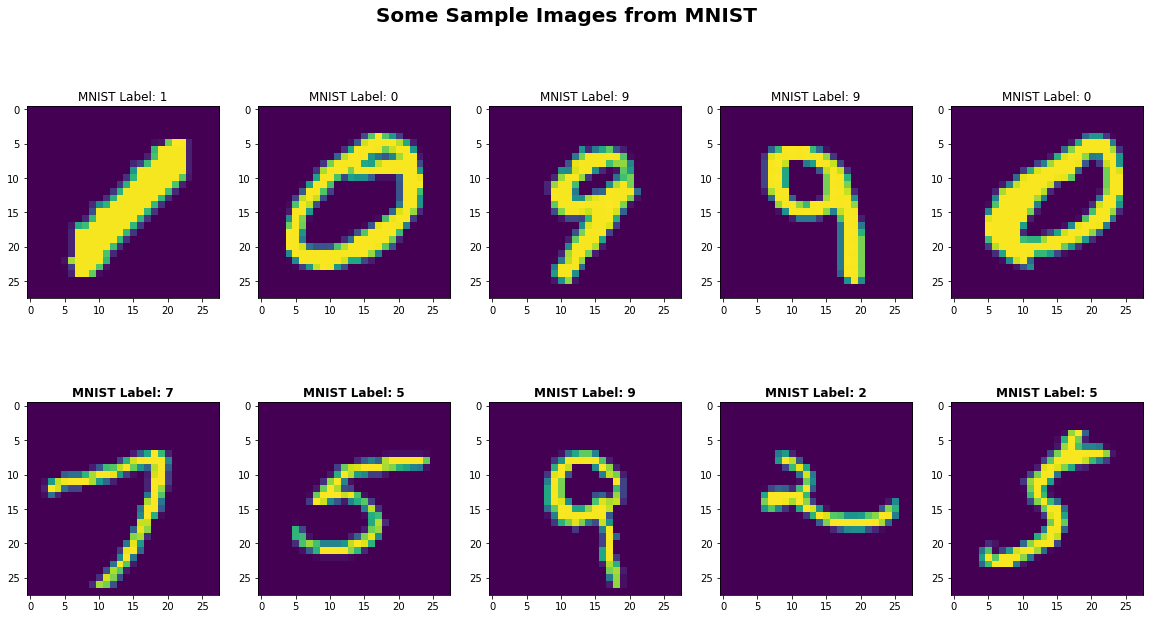

In [189]:
## Define our model 
MLR = MNIST_Logistic_Regression()

## Plot sample images
MLR.viz_training_images()


** Question 2:  Construct a softmax formulation in PyTorch of multinomial logistic regression with  Cross Entropy Loss.  **

** Question 3: Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs* **

We defined our multinomial logistic model with Cross Entropy Loss above.  Let's train it now.

In [190]:
MLR.fit()

** Question 4: What are the training and test set accuracies? **

** Question 5: Plot some (around 5) examples of misclassifications **

*Let's see what the accuracy on the training set.  Because we didn't define a validation set, we'll take the unorthodox step of determining classification accuracy on the entire training set (i.e. the same set on which we trained).  We get a classification accuracy of ~ 92% on the high side of what we'd get for classification accuracy on a Logistic Regression model for this data set.*

Dataset: Train 
Accuracy: 55420/60000 (92.4%)



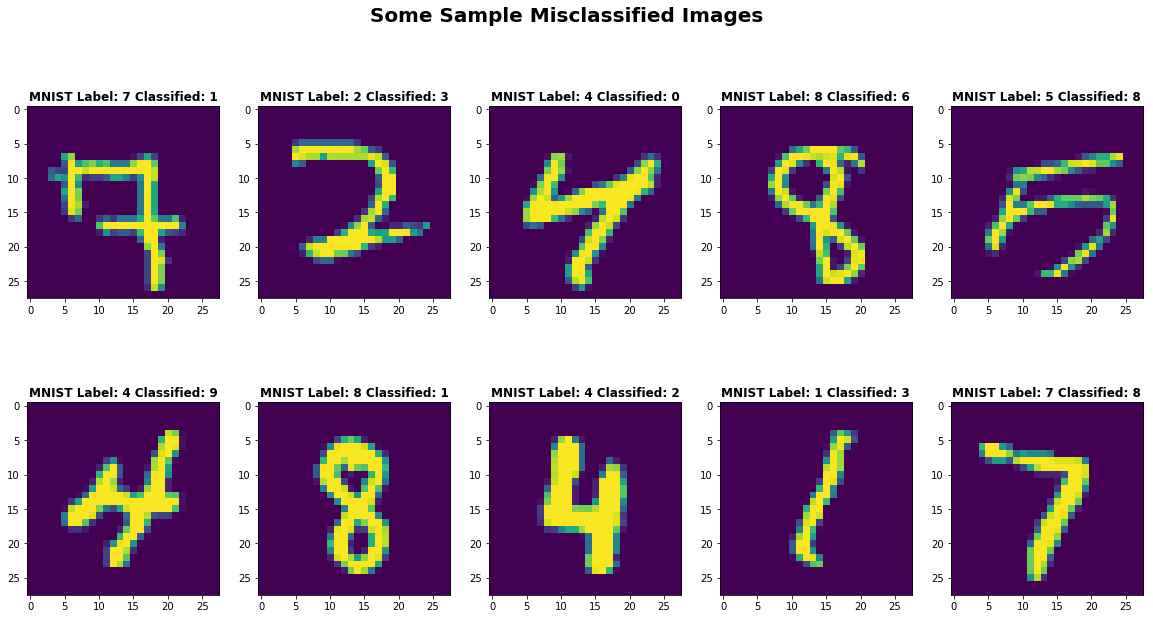

In [191]:
MLR.score("Train")

MLR.viz_misclassified_images()

*On the Test set, we also get a classification accuracy of ~ 92%.  This is similar accuracy to that which we obtained on the training set which suggests that our classification performance isn't due to overfitting.*

Dataset: Test 
Accuracy: 9222/10000 (92.2%)



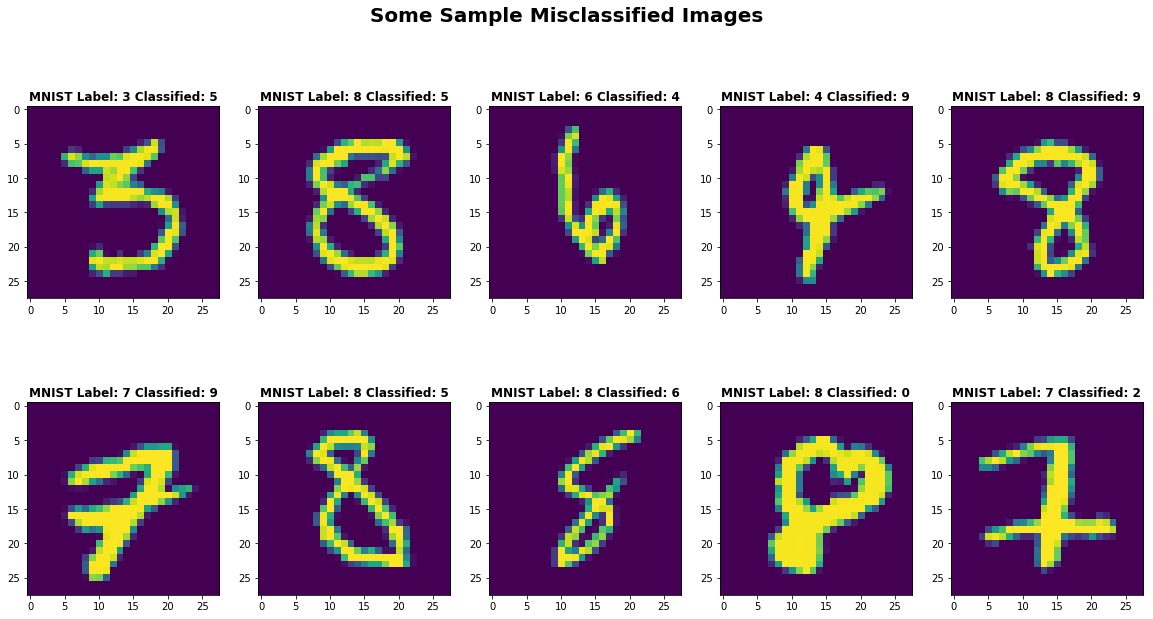

In [194]:
MLR.score("Test")

MLR.viz_misclassified_images()

A casual inspection of some of the the sample misclassified images seems to suggest that 8's, 7's and 4's make a number of appearances.  We also see a few examples of images that seem to show a bit of ambiguity which is picked up by our model.